In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

In [2]:
from matplotlib import font_manager,rc
import matplotlib
import platform

if platform.system() == 'Windows':
    path = 'c:/windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font',family = font_name)
elif platform.system() == 'Darwin':
    rc('font',family = 'AppleGothic')
else:
    print('Check your OS system')
    
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_excel('dataset_hw1.xlsx')

In [4]:
df.shape

(1411, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_ID         1411 non-null   int64  
 1   title            1411 non-null   object 
 2   genre            1408 non-null   object 
 3   running_time     1409 non-null   float64
 4   netizen_ratings  1411 non-null   float64
 5   num_reviews      1411 non-null   int64  
 6   num_article      1411 non-null   int64  
 7   country          1409 non-null   object 
 8   rating           1410 non-null   object 
 9   companyNm        1406 non-null   object 
 10  released_year    1411 non-null   int64  
 11  released_month   1411 non-null   int64  
 12  num_viewers      1411 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 143.4+ KB


In [6]:
df.describe()

,movie_ID,running_time,netizen_ratings,num_reviews,num_article,released_year,released_month,num_viewers
count,1.411000e+03,1409.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1.411000e+03
mean,2.012593e+07,110.545067,7.618731,4582.657690,1031.433026,2012.635719,6.406804,1.074520e+06
std,3.060055e+04,18.083797,1.111924,7316.325767,1866.725542,2.899102,3.465790,1.841526e+06
min,1.982002e+07,0.000000,2.530000,49.000000,0.000000,2005.000000,1.000000,2.260000e+04
25%,2.010038e+07,98.000000,7.010000,943.500000,38.000000,2010.000000,3.000000,1.079420e+05
50%,2.012641e+07,110.000000,7.800000,2175.000000,194.000000,2013.000000,7.000000,3.558510e+05
75%,2.015077e+07,121.000000,8.420000,5048.000000,1279.500000,2015.000000,9.000000,1.179833e+06
max,2.018766e+07,235.000000,9.380000,95111.000000,19996.000000,2018.000000,12.000000,1.761368e+07


# 제일 단순한 형태
문자형 변수는 버리고 결측 데이터 역시 버림<br>
해당 $r^2$를 최저기준으로 삼음

In [7]:
categorical_vars = ['title','genre','country','rating','companyNm']
numerical_vars = ['movie_ID','running_time','netizen_ratings','num_reviews','num_article','released_year','released_month','num_viewers']

In [10]:
temp_df = df.loc[:,numerical_vars]
temp_df = temp_df.dropna(axis=0,how='any')

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
temp_X = temp_df.iloc[:,:-1]
temp_y = temp_df.iloc[:,-1]
cross_val_score(lr,temp_X,temp_y,cv=10).mean()

0.6692193497772804

# 데이터 크롤링
목적<br>
- 감독 정보 수집
    - 감독이름 수집, 그외 빈 결측치가 있다면 수집, 다른 영화가 나올 수 있는데 개봉일 정보를 같이 수집
    - 불일치하는 것은 손으로 수집
- 결측치 정보 수집
    - CompanyNm, rating은 당장 수집 방법이 없으므로 수동 수집

In [12]:
df.isnull().sum()

movie_ID           0
title              0
genre              3
running_time       2
netizen_ratings    0
num_reviews        0
num_article        0
country            2
rating             1
companyNm          5
released_year      0
released_month     0
num_viewers        0
dtype: int64

In [13]:
# null 값이 두개 이상 있는 행 역시 존재
is_null_element = df.loc[df.isnull().sum(axis=1)>0].isnull()
is_null_element.sum(axis=1)

2       1
197     1
205     1
227     1
1345    1
1351    1
1352    1
1353    1
1365    2
1383    1
1403    2
dtype: int64

In [18]:
# 결측치가 존재하는 모든 정보이므로 다음 dataframe을 활용해 결측치 수집
null_info_df = pd.DataFrame(is_null_element.apply(lambda x:x.index[x == True].tolist() ,axis=1).values,
                            index = df.loc[is_null_element.sum(axis=1).index,'title'].values,
                            columns=['null column'])
null_info_df

,null column
작은 연못,[companyNm]
스테이트 오브 플레이,[companyNm]
코렐라인: 비밀의 문,[companyNm]
퍼블릭 에너미,[companyNm]
스타워즈: 라스트 제다이,[genre]
넛잡 2,[genre]
저수지 게임,[genre]
킬러의 보디가드,[running_time]
지오스톰,"[running_time, country]"
패터슨,[country]


In [15]:
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
import time
import re
import requests


In [16]:
# 빈값에 대한 정보를 같이 수집
def null_info_gathering(null_info : list ,soup):
    summaries = str(soup.select('div.info_group')[0].select('dd')[0]).split('</span>')
    summary = re.compile('[가-힣|0-9]+').findall(str(summaries))
    info = []
    if 'genre' in null_info:
        info.append(re.compile('[가-힣]+').findall(summaries[0])[0])
    if 'running_time' in null_info:
        temp = re.compile('[가-힣|0-9]+').findall(summaries[2])[0]
        if temp[-1]=='분':
            temp = temp[:-1]
        info.append(temp)
    if 'country' in null_info:
        info.append(re.compile('[가-힣|0-9]+').findall(summaries[1])[0])
    return info

In [17]:
directors = []
null_info_dict = {}
for i in tqdm_notebook(range(df.shape[0])):
# for i in tqdm_notebook([1363,1364,1365,1366]):
    movie_name,movie_year = df.iloc[i]['title'],df.iloc[i]['released_year']
    try:
        movie_name_expand = '영화 '+ movie_name
        url = "https://search.naver.com/search.naver?query=" + movie_name_expand.replace(' ','+')
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        released_year = soup.select('div.info_group')[1].select('dd')[0].text.split('.')[0]
        # 개봉일이 다르면 리메이크나 후속편등일 가능성이 있으니 이런 경우 수작업으로 조사
        if int(movie_year) != int(released_year):
            raise ValueError

        director = soup.select('strong.name.type_ell_2._html_ellipsis')[0].text
        directors.append(director)
        if movie_name in null_info_df.index:
            print(movie_name)
            null_movie_info = null_info_df.loc[null_info_df.index == movie_name].values[0,0]
            null_info_dict[movie_name] = dict(zip(null_movie_info,null_info_gathering(null_movie_info,soup)))
        time.sleep(0.1)
    except:
        directors.append(None)
    

작은 연못
스테이트 오브 플레이
코렐라인: 비밀의 문
퍼블릭 에너미
스타워즈: 라스트 제다이
넛잡 2
저수지 게임
지오스톰
패터슨



In [19]:
movie_names = ['킬러의 보디가드','로마의 휴일']
for movie_name in movie_names:
    movie_name_expand = '영화 '+ movie_name
    url = "https://search.naver.com/search.naver?query=" + movie_name_expand.replace(' ','+')
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    null_movie_info = null_info_df.loc[null_info_df.index == movie_name].values[0,0]
    null_info_dict[movie_name] = dict(zip(null_movie_info,null_info_gathering(null_movie_info,soup)))
null_info_dict

{'작은 연못': {},
 '스테이트 오브 플레이': {},
 '코렐라인: 비밀의 문': {},
 '퍼블릭 에너미': {},
 '스타워즈: 라스트 제다이': {'genre': '액션'},
 '넛잡 2': {'genre': '애니메이션'},
 '저수지 게임': {'genre': '스릴러'},
 '지오스톰': {'running_time': '109', 'country': '미국'},
 '패터슨': {'country': '프랑스'},
 '킬러의 보디가드': {'running_time': '117'},
 '로마의 휴일': {}}

In [20]:
for i in range(null_info_df.shape[0]):
    movie_name = null_info_df.index[i]
    null_column = null_info_df.values[i][0]
    null_dict_map = {movie_name:null_info_dict[movie_name]}
    for k, v in list(null_dict_map.values())[0].items():
        df.loc[df['title'] == movie_name,k] = v

In [21]:
df['감독'] = directors

In [22]:
df.isnull().sum()

movie_ID             0
title                0
genre                0
running_time         0
netizen_ratings      0
num_reviews          0
num_article          0
country              0
rating               1
companyNm            5
released_year        0
released_month       0
num_viewers          0
감독                 159
dtype: int64

In [23]:
null_df = df.loc[df.isnull().any(axis=1),:]
null_df = pd.concat([null_df['title'],null_df['released_year'], null_df.loc[:,null_df.isnull().sum() > 0]],axis=1)

In [24]:
null_df.reset_index(inplace=True)

In [25]:
null_df

,index,title,released_year,rating,companyNm,감독
0,2,작은 연못,2010,15세이상관람가,NaN,이상우
1,10,클로버필드,2008,15세이상관람가,씨제이엔터테인먼트,None
2,11,인디아나 존스 4 : 크리스탈 해골의 왕국,2008,12세이상관람가,씨제이엔터테인먼트,None
3,12,P.S. 아이 러브 유,2008,15세이상관람가,(주)쇼박스,None
4,14,엘라의 모험 : 해피엔딩의 위기,2008,전체관람가,(주)쇼박스,None
...,...,...,...,...,...,...
158,1358,범죄도시,2017,청소년관람불가,(주)키위미디어그룹,None
159,1370,보스 베이비,2017,전체관람가,씨제이이앤엠(주),None
160,1386,더 서클,2017,12세이상관람가,씨네그루(주)키다리이엔티,None
161,1391,47 미터,2017,15세이상관람가,씨네그루(주)키다리이엔티,None


In [26]:
# 1편일 가능성이 있음
directors = []
null_info_dict = {}
for i in tqdm_notebook(range(null_df.shape[0])):
    try:
        movie_name, movie_year = null_df.iloc[i]['title'], null_df.iloc[i]['released_year']
        movie_name_expand = '영화 '+ movie_name+str(1)
        url = "https://search.naver.com/search.naver?query=" + movie_name_expand.replace(' ','+')
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        released_year = soup.select('div.info_group')[1].select('dd')[0].text.split('.')[0]
        # 개봉일이 다르면 리메이크나 후속편등일 가능성이 있으니 이런 경우 수작업으로 조사
        if int(movie_year) != int(released_year):
            raise ValueError
        director = soup.select('strong.name.type_ell_2._html_ellipsis')[0].text
        directors.append(director)
        if movie_name in null_info_df.index:
            print(movie_name)
            null_movie_info = null_info_df.loc[null_info_df.index == movie_name].values[0,0]
            null_info_dict[movie_name] = dict(zip(null_movie_info,null_info_gathering(null_movie_info,soup)))
        time.sleep(0.1)
    except:
        directors.append(None)

킬러의 보디가드



In [27]:
df['감독'] = df['감독'].fillna(dict(zip(null_df['index'], directors)))
null_df2 = df.loc[df.isnull().any(axis=1),:]
null_df2 = pd.concat([null_df2['title'],null_df2['released_year'], null_df2.loc[:,null_df2.isnull().sum() > 0]],axis=1)
null_df2.reset_index(inplace=True)
null_df2

,index,title,released_year,rating,companyNm,감독
0,2,작은 연못,2010,15세이상관람가,NaN,이상우
1,11,인디아나 존스 4 : 크리스탈 해골의 왕국,2008,12세이상관람가,씨제이엔터테인먼트,None
2,12,P.S. 아이 러브 유,2008,15세이상관람가,(주)쇼박스,None
3,14,엘라의 모험 : 해피엔딩의 위기,2008,전체관람가,(주)쇼박스,None
4,15,아더와 미니모이-제1탄비밀원정대의출정,2015,전체관람가,롯데쇼핑㈜롯데엔터테인먼트,None
...,...,...,...,...,...,...
100,1309,벤허,2016,12세이상관람가,롯데쇼핑㈜롯데엔터테인먼트,None
101,1321,반지의 제왕 : 반지원정대 (확장판),2010,12세이상관람가,(주)디스테이션,None
102,1326,반지의 제왕 : 두개의 탑 (확장판),2017,12세이상관람가,(주)디스테이션,None
103,1386,더 서클,2017,12세이상관람가,씨네그루(주)키다리이엔티,None


In [28]:
# "영화" 키워드 없이
directors = []
null_info_dict = {}
for i in tqdm_notebook(range(null_df2.shape[0])):
    try:
        movie_name, movie_year = null_df2.iloc[i]['title'], null_df2.iloc[i]['released_year']
        movie_name_expand = movie_name
        url = "https://search.naver.com/search.naver?query=" + movie_name_expand.replace(' ','+')
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        released_year = soup.select('div.info_group')[1].select('dd')[0].text.split('.')[0]
        # 개봉일이 다르면 리메이크나 후속편등일 가능성이 있으니 이런 경우 수작업으로 조사
        if int(movie_year) != int(released_year):
            raise ValueError
        director = soup.select('strong.name.type_ell_2._html_ellipsis')[0].text
        directors.append(director)
        if movie_name in null_info_df.index:
            print(movie_name)
            null_movie_info = null_info_df.loc[null_info_df.index == movie_name].values[0,0]
            null_info_dict[movie_name] = dict(zip(null_movie_info,null_info_gathering(null_movie_info,soup)))
        time.sleep(0.1)
    except:
        directors.append(None)

스테이트 오브 플레이
코렐라인: 비밀의 문
퍼블릭 에너미



In [29]:
df['감독'] = df['감독'].fillna(dict(zip(null_df['index'], directors)))
null_df3 = df.loc[df.isnull().any(axis=1),:]
null_df3 = pd.concat([null_df3['title'],null_df3['released_year'], null_df3.loc[:,null_df3.isnull().sum() > 0]],axis=1)
null_df3.reset_index(inplace=True)
null_df3

,index,title,released_year,rating,companyNm,감독
0,2,작은 연못,2010,15세이상관람가,NaN,이상우
1,14,엘라의 모험 : 해피엔딩의 위기,2008,전체관람가,(주)쇼박스,None
2,15,아더와 미니모이-제1탄비밀원정대의출정,2015,전체관람가,롯데쇼핑㈜롯데엔터테인먼트,None
3,20,말할 수 없는 비밀,2008,12세이상관람가,(주)스폰지이엔티,None
4,66,나니아 연대기:캐스피언 왕자,2008,전체관람가,한국소니픽쳐스릴리징브에나비스타영화㈜,None
...,...,...,...,...,...,...
75,1309,벤허,2016,12세이상관람가,롯데쇼핑㈜롯데엔터테인먼트,NaN
76,1321,반지의 제왕 : 반지원정대 (확장판),2010,12세이상관람가,(주)디스테이션,NaN
77,1326,반지의 제왕 : 두개의 탑 (확장판),2017,12세이상관람가,(주)디스테이션,NaN
78,1386,더 서클,2017,12세이상관람가,씨네그루(주)키다리이엔티,NaN


In [196]:
# 나머지에 대해서는 수기로 입력
# null_df3.to_ecxel('temptemp.xlsx',index=False)

In [30]:
null_df = pd.read_excel('temp.xlsx')

In [32]:
df['감독'] = df['감독'].fillna(dict(zip(null_df['index'], null_df['감독'])))
df['rating'] = df['rating'].fillna(dict(zip(null_df['index'], null_df['rating'])))
df['companyNm'] = df['companyNm'].fillna(dict(zip(null_df['index'], null_df['companyNm'])))

In [55]:
df.isnull().sum()

movie_ID           0
title              0
genre              0
running_time       0
netizen_ratings    0
num_reviews        0
num_article        0
country            0
rating             0
companyNm          0
released_year      0
released_month     0
num_viewers        0
감독                 0
dtype: int64

In [88]:
df.to_excel('full.xlsx',index=False)

In [3]:
df = pd.read_excel('full.xlsx')

# 탐색
시도해볼만한 것들<br>
- movie id에 담긴 정보가 있을지
- 시각화
- running_time 변수 처리
- 이상치
- 결측치 제거 or 대치
- 문자형 변수에 대한 변수 선택(anova 등)
- 문자형 변수의 label encoding 혹은 onehot encoding
- released_year, month 변수는 어떻게 처리할지
- 변수 선택(lasso)

In [5]:
df.describe()

,movie_ID,running_time,netizen_ratings,num_reviews,num_article,released_year,released_month,num_viewers
count,1.411000e+03,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1.411000e+03
mean,2.012593e+07,110.548547,7.618731,4582.657690,1031.433026,2012.635719,6.406804,1.074520e+06
std,3.060055e+04,18.071831,1.111924,7316.325767,1866.725542,2.899102,3.465790,1.841526e+06
min,1.982002e+07,0.000000,2.530000,49.000000,0.000000,2005.000000,1.000000,2.260000e+04
25%,2.010038e+07,98.000000,7.010000,943.500000,38.000000,2010.000000,3.000000,1.079420e+05
50%,2.012641e+07,110.000000,7.800000,2175.000000,194.000000,2013.000000,7.000000,3.558510e+05
75%,2.015077e+07,121.000000,8.420000,5048.000000,1279.500000,2015.000000,9.000000,1.179833e+06
max,2.018766e+07,235.000000,9.380000,95111.000000,19996.000000,2018.000000,12.000000,1.761368e+07


In [8]:
df[['movie_ID','title','released_year','released_month']]

,movie_ID,title,released_year,released_month
0,19820019,만추,2011,2
1,20050082,이터널 선샤인,2005,11
2,20061214,작은 연못,2010,4
3,20061223,소년은 울지 않는다,2008,11
4,20068576,그날의 분위기,2016,1
...,...,...,...,...
1406,20179491,아토믹 블론드,2017,8
1407,20179662,파워레인져스: 더 비기닝,2017,4
1408,20179901,혹성탈출: 종의 전쟁,2017,8
1409,20179942,러빙 빈센트,2017,11


# movie_ID

In [9]:
# movie_ID 앞 4자리는 개봉연도로 보인다.
# 일치하지 않는 것들이 몇개 있어 새로운 특성으로 추가해줄까 하였으나 3이상 차이나는 것들이 거의 없기 때문에 무시하도록 함
condition = np.abs(df['movie_ID'].astype('str').str[:4].astype('int') - df['released_year']) > 2
df.loc[condition,['movie_ID','title','released_year','released_month']]

,movie_ID,title,released_year,released_month
0,19820019,만추,2011,2
2,20061214,작은 연못,2010,4
4,20068576,그날의 분위기,2016,1
5,20068590,인류멸망 보고서,2012,4
15,20071015,아더와 미니모이-제1탄비밀원정대의출정,2015,12
26,20078561,명탐정 코난:감벽의 관,2018,2
150,20088506,26년,2012,11
301,20098169,쥬라기 월드,2015,6
1321,20168324,반지의 제왕 : 반지원정대 (확장판),2010,12


In [10]:
df['movie_ID'].astype('str').str[4:].nunique()

1284

In [11]:
categorical_vars = ['title','genre','country','rating','companyNm']
i=4
temp = df[categorical_vars[i]].value_counts().index[0]
df.groupby(categorical_vars[i]).get_group(temp)['movie_ID'].astype('str').str[4:]

15      1015
16      1047
17      1060
46      0146
58      0350
        ... 
1325    8501
1330    8754
1346    0607
1351    1817
1385    6121
Name: movie_ID, Length: 163, dtype: object

movie ID의 앞자리 정보는 개봉년도와 겹침<br>
뒷자리에는 다른 categorical 변수등과 합치하는 어떤 정보가 있어보이지는 않음<br>
$\Rightarrow$movie_ID는 사용하지 않음

In [12]:
movie_ID = df['movie_ID']
df = df.drop('movie_ID',axis=1)

추가로 title name 역시 그 자체로는 의미가 있을 것 같지 않음<br>
단 강렬한 문구 등에 끌릴 수도 있다는 생각이 들어 title의 길이 정보만을 남겨놓도록 하겠음<br>
(다른 변수들과 마찬가지로 여러 판단을 거쳐 제거하든지 사용하든지 결정)

In [21]:
df['title_len'] = df['title'].str.len()
title = df['title']
# df = df.drop(['title'],axis=1)

개봉연도는 2005년과 2018년에 매우 희소하므로 그대로 사용할지, 이를 다른 년도로 편입시킬지, 변수 자체를 제거할지를 시각화 등으로 판단

In [14]:
df['released_year'].value_counts().sort_index()

2005      1
2008    134
2009    126
2010    143
2011    141
2012    143
2013    124
2014    140
2015    151
2016    155
2017    150
2018      3
Name: released_year, dtype: int64

# 시각화

In [34]:
categorical_vars = ['genre','country','rating','companyNm']
numerical_vars = ['running_time','netizen_ratings','num_reviews','num_article','title_len','num_viewers']

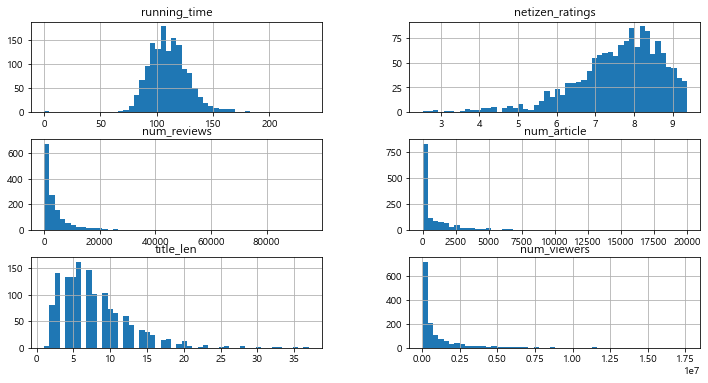

In [38]:
df[numerical_vars].hist(bins=50,figsize=(12,6))
plt.show()

In [7]:
# num_articles(log_num_article)는 0으로의 쏠림이 심함
print(df.loc[df['num_article'] == 0,'title'].tolist())

['꿀벌대소동', 'P.S. 아이 러브 유', '엘라의 모험 : 해피엔딩의 위기', '아더와 미니모이-제1탄비밀원정대의출정', '써티 데이즈 오브 나이트', '에이리언 VS 프레데터2 ', '원스어폰어타임', '에반게리온 : 서(序)', '스파이더위크가의 비밀', '나의 특별한 사랑이야기', '내가 숨쉬는 공기', '패솔로지', '라스베가스에서만 생길 수 있는 일', '겟 썸', '디 아이', '알이씨(Rec)', '극장판 도라에몽:진구의 마계대모험 7인의 마법사', '스페이스 침스:우주선을 찾아서', '월ㆍE', '미스 페티그루의 어느 특별한 하루', '동키호테', '하우 투 루즈 프렌즈', '내 친구의 사생활', '언더 더 쎄임 문', '쏘우 V', '잃어버린 세계를 찾아서', '볼트', '마다가스카 2', '잉크하트 : 어둠의 부활', '문프린세스 : 문에이커의 비밀', '작은 영웅 데스페로', '신부들의 전쟁', '미쓰 루시힐', '몬스터 vs 에이리언', '13구역: 얼티메이텀', '제독의 연인', '주온-원혼의 부활', '극장판 도라에몽: 진구의 공룡대탐험', '아이스 에이지 3: 공룡시대', '드림업', '퍼펙트 겟어웨이', '라르고 윈치', '하이 레인', '어글리 트루스', 'S러버', '파이널 데스티네이션 4', '뉴욕 아이 러브 유', '마이클 잭슨의 디스 이즈 잇', '에반게리온: 파', 'G-포스: 기니피그 특공대', '오션스', '타이탄', '사랑은 언제나 진행중', '포스 카인드', '대병소장', '케로로 더 무비 5: 기적의 사차원섬', '여대생 기숙사', '킬러 인사이드 미', '극장판 도라에몽: 진구의 인어대해전', '프레데터스', '22 블렛', '노다메 칸타빌레 최종악장', '극장판 메탈 베이블레이드 VS 태양 작열의 침략자 솔블레이즈', '워터 포 엘리펀트', '마당을 나온 암탉', '쥴리의 육지 대모험', '콜롬비아나', '더 킥', '극장판 포켓몬스터 베스트 위시 「비크티니와 흑의 영웅 제크로무」', '청원', '하트 

In [11]:
# 영화 제목으로 봐서 0을 이상치로 판단하고 이를 채우도록 하겠음
# 이상치라 판단한 0을 제외한 상태에서 num_reviews와 상관계수가 높으므로 num_reviews를 이용해 채우도록 한다.
cond1 = df['num_article']==0
df.drop(df[cond1].index)[['num_article','num_reviews']].corr()

,num_article,num_reviews
num_article,1.0000,0.6103
num_reviews,0.6103,1.0000


In [31]:
# num_reviews의 값을 20개의 구간으로 나눠 이상치가 속하는 구간의 중위값으로 대치하도록 한다.

df.loc[cond1,'num_article'] = np.nan
df['temp_num_reviews_bin'] = pd.Categorical(pd.qcut(df['num_reviews'],20)).codes
df['fill_num_article'] = df['num_article'].fillna(df.groupby('temp_num_reviews_bin')['num_article'].transform('median'))
df[['fill_num_article','num_reviews','num_viewers']].corr()

,fill_num_article,num_reviews,num_viewers
fill_num_article,1.000000,0.618657,0.603354
num_reviews,0.618657,1.000000,0.842496
num_viewers,0.603354,0.842496,1.000000


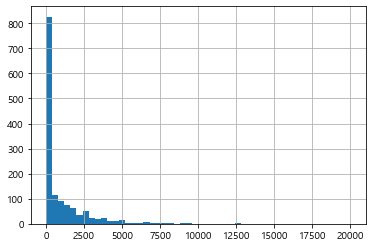

In [32]:
df['fill_num_article'].hist(bins=50)

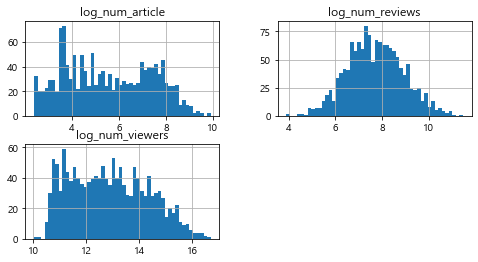

In [33]:
# num_article,num_reviews와 num_viewers는 쏠림 현상이 심하므로 log를 취하도록 한다.
# log_num_article는 0으로의 쏠림이 여전히 존재하므로 log를 쓸지 그냥 데이터를 사용할지 추후 판단
df[['log_num_article','log_num_reviews','log_num_viewers']] = np.log(df[['fill_num_article','num_reviews','num_viewers']]+1)
df[['log_num_article','log_num_reviews','log_num_viewers']].hist(bins=50,figsize=(8,4))
plt.show()

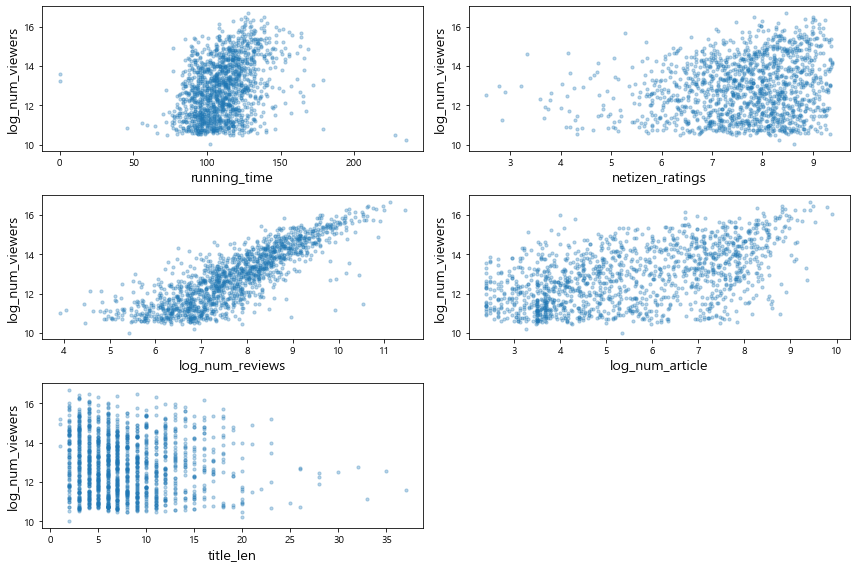

In [34]:
# 응답변수 log(num_viewers)와의 관계
using_vars = ['running_time','netizen_ratings','log_num_reviews','log_num_article','title_len']
fig,axes = plt.subplots(3,2,figsize = (12,8))
for i,ax in enumerate(axes.flatten()):
    if i==5:
        ax.axis('off')
        break
    df.plot(x = using_vars[i],y = 'log_num_viewers',kind='scatter',alpha = 0.3, ax=ax, s=10)
    ax.set_xlabel(using_vars[i],fontsize=14)
    ax.set_ylabel('log_num_viewers',fontsize=14)
plt.tight_layout()


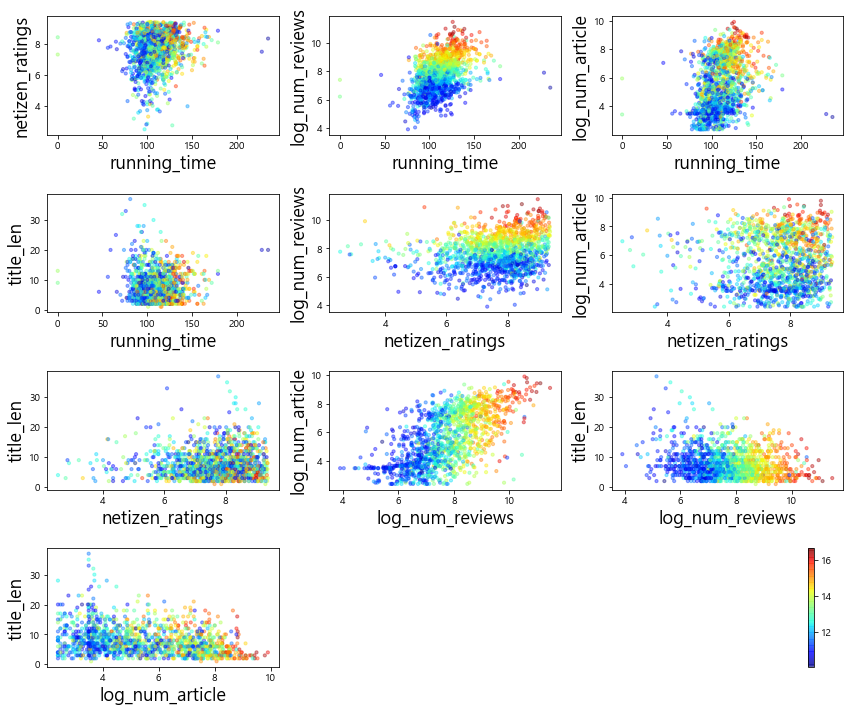

In [29]:
# 응답변수를 제외하고 나머지 변수들간의 관계
using_vars = ['running_time','netizen_ratings','log_num_reviews','log_num_article','title_len']
fig, axes = plt.subplots(4,3,figsize = (12,10))
axes = axes.flatten()
cnt = 0
for i in range(len(using_vars)):
    for j in range(i+1,len(using_vars)):
        x = using_vars[i]
        y = using_vars[j]
        if cnt==1:
            ax = axes[cnt].scatter(df[x],df[y],s = 10,c = df['log_num_viewers'],cmap=plt.get_cmap("jet"),alpha=0.4)
        else:
            axes[cnt].scatter(df[x],df[y],s = 10,c = df['log_num_viewers'],cmap=plt.get_cmap("jet"),alpha=0.4)
        axes[cnt].set_xlabel(x,fontsize=18)
        axes[cnt].set_ylabel(y,fontsize=18)
        cnt += 1

plt.tight_layout()
axes[10].axis('off')
axes[11].axis('off')
plt.colorbar(ax)


running time은 중간에 존재할 수록 관객 수가 많으므로 범주를 나눠서 평가 -> ex) 'short','proper','long'

In [35]:
quantile = pd.qcut(df['running_time'],4)
df.groupby(quantile).agg(['count','mean','min','max'])[['num_viewers','log_num_viewers']]

num_viewers                                log_num_viewers  \
                     count          mean    min       max           count   
running_time                                                                
(-0.001, 98.0]         366  4.722519e+05  36420   5583596             366   
(98.0, 110.0]          370  6.949240e+05  22600  10296101             370   
(110.0, 121.0]         334  1.013922e+06  35296  11565479             334   
(121.0, 235.0]         341  2.192176e+06  27440  17613682             341   

                                                 
                     mean        min        max  
running_time                                     
(-0.001, 98.0]  12.243581  10.502901  15.535344  
(98.0, 110.0]   12.600652  10.025749  16.147276  
(110.0, 121.0]  13.042919  10.471553  16.263535  
(121.0, 235.0]  13.637759  10.219794  16.684187

C:\Users\hp\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


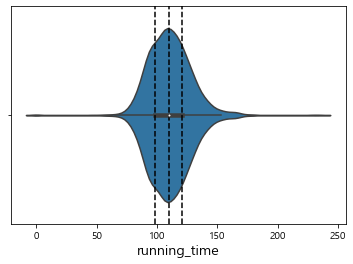

In [36]:
boundaries = [val.right for val in pd.Categorical(quantile).categories]
fig, ax = plt.subplots()
sns.violinplot(df['running_time'], ax=ax,)
for boundary in boundaries[:-1]:
    ax.axvline(boundary,color='black',ls='--')
ax.set_xlabel('running_time',fontsize=14)


running time은 4개의 범주로 나누기로 한다.

In [37]:
df['running_time_bins']=pd.qcut(df['running_time'],4,labels=['short','lower middle','upper middle','long'])

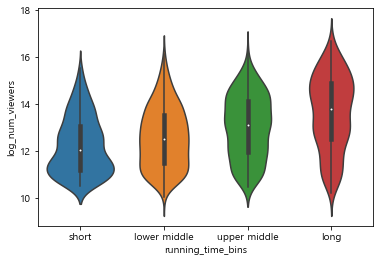

In [38]:
sns.violinplot(x=df['running_time_bins'],y=df['log_num_viewers'])

In [39]:
# 전부 정규분포를 따르지 않음
from scipy.stats import shapiro
test_list = [df.loc[df['running_time_bins']=='short','log_num_viewers'],df.loc[df['running_time_bins']=='lower middle','log_num_viewers'],
         df.loc[df['running_time_bins']=='upper middle','log_num_viewers'],df.loc[df['running_time_bins']=='long','log_num_viewers']]
for values in test_list:
    print(shapiro(values))

ShapiroResult(statistic=0.9436658024787903, pvalue=1.414448141945357e-10)
ShapiroResult(statistic=0.9721457362174988, pvalue=1.5484080222449847e-06)
ShapiroResult(statistic=0.9716452956199646, pvalue=3.938024292438058e-06)
ShapiroResult(statistic=0.9684948921203613, pvalue=9.425843359167629e-07)


In [40]:
# p-value가 0.05 미만이므로 귀무가설을 기각, 네 그룹간 평균 차이가 있다는 대립가설을 받아들이고 runnig_time은 네 범주로 나눠서 진행
from scipy.stats import kruskal
kruskal(test_list[0],test_list[1],test_list[2],test_list[3])

KruskalResult(statistic=166.5034661332048, pvalue=7.235501554425752e-36)

In [41]:
df.columns

Index(['movie_ID', 'title', 'genre', 'running_time', 'netizen_ratings',
       'num_reviews', 'num_article', 'country', 'rating', 'companyNm',
       'released_year', 'released_month', 'num_viewers', '감독',
       'temp_num_reviews_bin', 'fill_num_article', 'log_num_article',
       'log_num_reviews', 'log_num_viewers', 'title_len', 'running_time_bins'],
      dtype='object')

# 날짜 변수의 처리

In [42]:
date_vars = ['released_year','released_month']

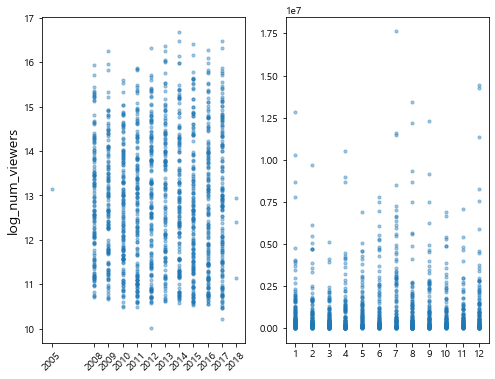

In [43]:
fig,axes = plt.subplots(1,2,figsize=(8,6))
axes[0].scatter(y=df['log_num_viewers'], x=df['released_year'], alpha=0.4,s=10)
axes[0].set_xticks(ticks=[2005]+list(range(2008,2019)))
axes[0].set_xticklabels(labels = [2005]+list(range(2008,2019)), rotation=45)
axes[0].set_ylabel('log_num_viewers',fontsize=14)
axes[1].scatter(y=df['num_viewers'], x=df['released_month'], alpha=0.4,s=10)
axes[1].set_xticks(ticks=list(range(1,13)))
axes[1].set_xticklabels(labels = list(range(1,13)))

In [44]:
# 표본이 매우 적은 2005년과 2018년을 제외하면 차이가 거의 발견되지 않음
i=0
df.groupby(date_vars[i]).agg(['count','mean','min','max','var'])['log_num_viewers']

,count,mean,min,max,var
released_year,,,,,
2005,1,13.135497,13.135497,13.135497,NaN
2008,134,12.890409,10.720864,15.925181,1.750623
2009,126,12.882190,10.675492,16.253792,1.675356
2010,143,12.745617,10.484557,15.595020,1.627326
2011,141,12.752857,10.502901,15.867685,2.135518
2012,143,12.966642,10.025749,16.326697,2.208822
2013,124,13.168251,10.616829,16.365831,2.184397
2014,140,12.876344,10.573673,16.684187,2.304117
2015,151,12.702914,10.541492,16.411810,2.267148


In [45]:
# 마찬가지로 모두 정규분포라 보기 어려움
for date in np.unique(df[date_vars[i]]):
    if date in [2005,2018]:
        continue
    print(shapiro(df.loc[df[date_vars[i]]==date,'log_num_viewers']))

ShapiroResult(statistic=0.9663902521133423, pvalue=0.0021438023541122675)
ShapiroResult(statistic=0.9766664505004883, pvalue=0.028087781742215157)
ShapiroResult(statistic=0.9718918204307556, pvalue=0.004838734865188599)
ShapiroResult(statistic=0.9528822898864746, pvalue=9.7512653155718e-05)
ShapiroResult(statistic=0.9673179984092712, pvalue=0.0017053148476406932)
ShapiroResult(statistic=0.9718518257141113, pvalue=0.010763101279735565)
ShapiroResult(statistic=0.9595891833305359, pvalue=0.0003849383210763335)
ShapiroResult(statistic=0.9476617574691772, pvalue=1.9778901332756504e-05)
ShapiroResult(statistic=0.9477489590644836, pvalue=1.5717132555437274e-05)
ShapiroResult(statistic=0.9610037207603455, pvalue=0.00030334555776789784)


In [46]:
# 년도별 응답변수의 값이 같다는 귀무가설을 기각하지 않음(2005,2018은 제외)
test_list = [df.loc[df[date_vars[i]]==date,'log_num_viewers'] for date in np.unique(df[date_vars[i]]) if date not in [2005,2008]]
kruskal(test_list[0],test_list[1],test_list[2],test_list[3],test_list[4],
        test_list[5],test_list[6],test_list[7],test_list[8],test_list[9])

KruskalResult(statistic=11.055088116252954, pvalue=0.2719518261862074)

In [47]:
# 월별 데이터에 대해서는 일단 그룹의 분포가 다르다는 대립가설을 채택하고 남겨두기로함
# 월별 데이터를 범주형으로 처리할까 고민했으나 일단은 남겨두기로한다.
i=1
display(df.groupby(date_vars[i]).agg(['count','mean','min','max','var'])['log_num_viewers'])
for date in np.unique(df[date_vars[i]]):
    print(shapiro(df.loc[df[date_vars[i]]==date,'log_num_viewers']))
    
test_list = [df.loc[df[date_vars[i]]==date,'log_num_viewers'] for date in np.unique(df[date_vars[i]]) if date not in [2005,2008]]
print(kruskal(test_list[0],test_list[1],test_list[2],test_list[3],test_list[4],
        test_list[5],test_list[6],test_list[7],test_list[8],test_list[9],
       test_list[10],test_list[11]))

,count,mean,min,max,var
released_month,,,,,
1,129,12.997531,10.487991,16.365831,1.794428
2,127,12.784238,10.219794,16.088374,1.782302
3,117,12.564483,10.553362,15.452212,1.596601
4,126,12.624660,10.600677,16.166362,2.169741
5,96,13.125002,10.632991,15.744116,1.906154
6,103,12.993921,10.612607,15.867685,2.327946
7,115,13.312507,10.627358,16.684187,2.866813
8,139,12.676820,10.025749,16.411810,2.249041
9,125,12.838101,10.471553,16.326697,2.278267


ShapiroResult(statistic=0.9860108494758606, pvalue=0.2100299894809723)
ShapiroResult(statistic=0.9759342074394226, pvalue=0.023022733628749847)
ShapiroResult(statistic=0.9643051624298096, pvalue=0.0033339194487780333)
ShapiroResult(statistic=0.9446437358856201, pvalue=5.900801988900639e-05)
ShapiroResult(statistic=0.958907961845398, pvalue=0.004285972099751234)
ShapiroResult(statistic=0.9537916779518127, pvalue=0.001222640392370522)
ShapiroResult(statistic=0.9445221424102783, pvalue=0.00012430470087565482)
ShapiroResult(statistic=0.950944721698761, pvalue=7.653533975826576e-05)
ShapiroResult(statistic=0.9539158940315247, pvalue=0.0003110464022029191)
ShapiroResult(statistic=0.9570062756538391, pvalue=0.0006136081065051258)
ShapiroResult(statistic=0.9637163281440735, pvalue=0.007467171177268028)
ShapiroResult(statistic=0.9705490469932556, pvalue=0.014725541695952415)
KruskalResult(statistic=29.54902316949086, pvalue=0.0018644350519613502)


In [48]:
df.to_excel('중간.xlsx',index=False)